In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from falchooser.malscraper.dbaccess import Database, Anime, Statistics
from falchooser.malscraper.scraper import read_titles

In [2]:
DB = Database()
SESSION = DB.get_session()

In [3]:
def get_latest_day() -> int:
    return SESSION.query(Statistics.day).order_by(Statistics.day.desc()).first()[0]

In [4]:
def get_statistics(anime: str="", id=None, first_day: int=0, last_day: int=-1):
    # TODO: first_day and last_day do nothing atm.
    # TODO: Returning the anime title for each day seems redundant.
    if last_day == -1:
        last_day = get_latest_day()
    if id:
        sqlfilter = Anime.id == id
    else:
        sqlfilter = Anime.title.ilike("%"+anime+"%")
    stats = SESSION.query(Anime.title, Statistics.day, Statistics.watching + Statistics.completed, Statistics.users,
                          Statistics.ranked, Statistics.popularity, Statistics.members, Statistics.favorites
                         ).join(Statistics, Statistics.anime==Anime.id).filter(sqlfilter
                                                                              ).order_by(Anime.title, Statistics.day)
    return stats.all()

In [5]:
def get_anime_and_id(filtered_titles=[]):
    query = [column for column in SESSION.query(Anime.title, Anime.id) if column[0] not in filtered_titles]
    return zip(*query)

In [6]:
filtered_titles = ["Boku no Hero Academia 2nd Season",
                   "Boruto: Naruto Next Generations",
                   "Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka Gaiden: Sword Oratoria",
                   "Shingeki no Kyojin Season 2"]
anime_titles, anime_ids = get_anime_and_id(filtered_titles=filtered_titles)
assert len(anime_titles) == 40, "There should be 40 titles with its statistics."
up_to_days = get_latest_day()
print("Evaluating the following series for the first {} days of FAL:".format(up_to_days))
print("-------------------------------------------------------------")
for anime in anime_titles:
    print(anime)

Evaluating the following series for the first 7 days of FAL:
-------------------------------------------------------------
Alice to Zouroku
Atom: The Beginning
Busou Shoujo Machiavellianism
Clockwork Planet
Eromanga-sensei
Frame Arms Girl
Fukumenkei Noise
Gin no Guardian
Granblue Fantasy The Animation
Kabukibu!
Oushitsu Kyoushi Haine
Re:Creators
Sakura Quest
Sakurada Reset
Shuumatsu Nani Shitemasu ka? Isogashii desu ka? Sukutte Moratte Ii desu ka?
Tsuki ga Kirei
Zero kara Hajimeru Mahou no Sho
Berserk (2017)
Cinderella Girls Gekijou
Hinako Note
Kaitou Tenshi Twin Angel (TV)
Kenka Banchou Otome: Girl Beats Boys
Kyoukai no Rinne (TV) 3rd Season
Love Kome: We Love Rice
Natsume Yuujinchou Roku
Quan Zhi Gao Shou
Renai Boukun
Rokudenashi Majutsu Koushi to Akashic Records
Room Mate: One Room Side M
Seikaisuru Kado
Sekai no Yami Zukan
Sin: Nanatsu no Taizai
Souryo to Majiwaru Shikiyoku no Yoru ni...
Starmyu 2nd Season
Tsugumomo
Uchouten Kazoku 2
Warau Salesman New
YuâGiâOh! VRAINS
Saenai H

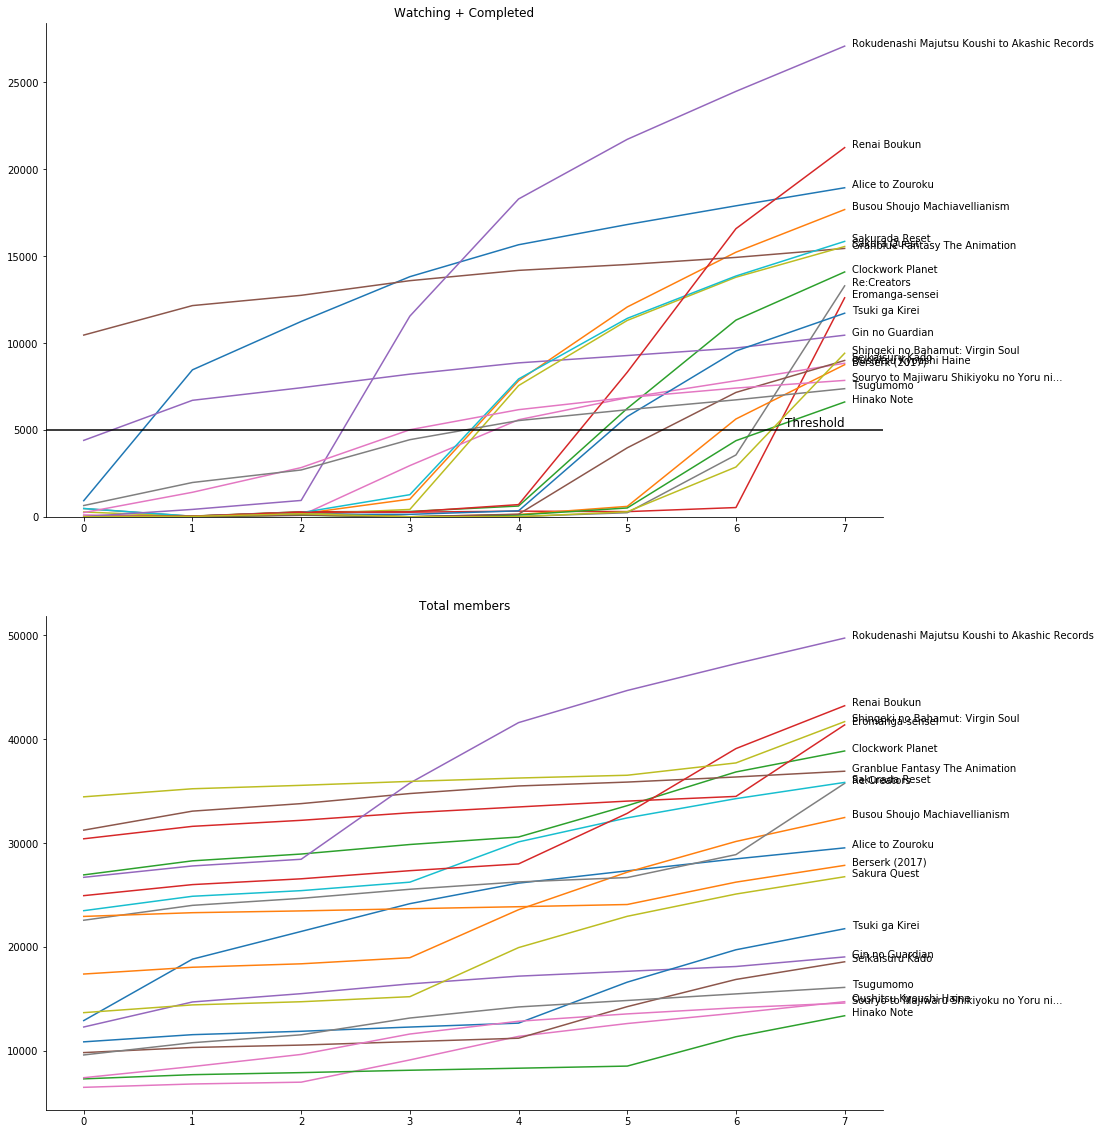

In [7]:
watching_threshold = 5000
watching_index = 2
member_index = 6
fig = plt.figure(figsize=(15,20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("Watching + Completed")
ax2.set_title("Total members")
for id in anime_ids:
    anime_stats = get_statistics(id=id)
    if len(anime_stats) >= up_to_days and anime_stats[up_to_days][watching_index] > watching_threshold:
        title = anime_stats[0][0]
        days = [stat[1] for stat in anime_stats]
        watching = [stat[watching_index] for stat in anime_stats]
        members = [stat[member_index] for stat in anime_stats]
        ax1.plot(days, watching, label=title)
        ax1.text(up_to_days * 1.01, watching[-1], title)
        ax2.plot(days, members, label=title)
        ax2.text(up_to_days * 1.01, members[-1], title)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax1.set_ylim(bottom=0)
ax1.axhline(watching_threshold, color="black")
ax1.text(up_to_days, watching_threshold, "Threshold", color="black",
        horizontalalignment="right", verticalalignment="bottom", size="large")
plt.xticks(days)
plt.show()

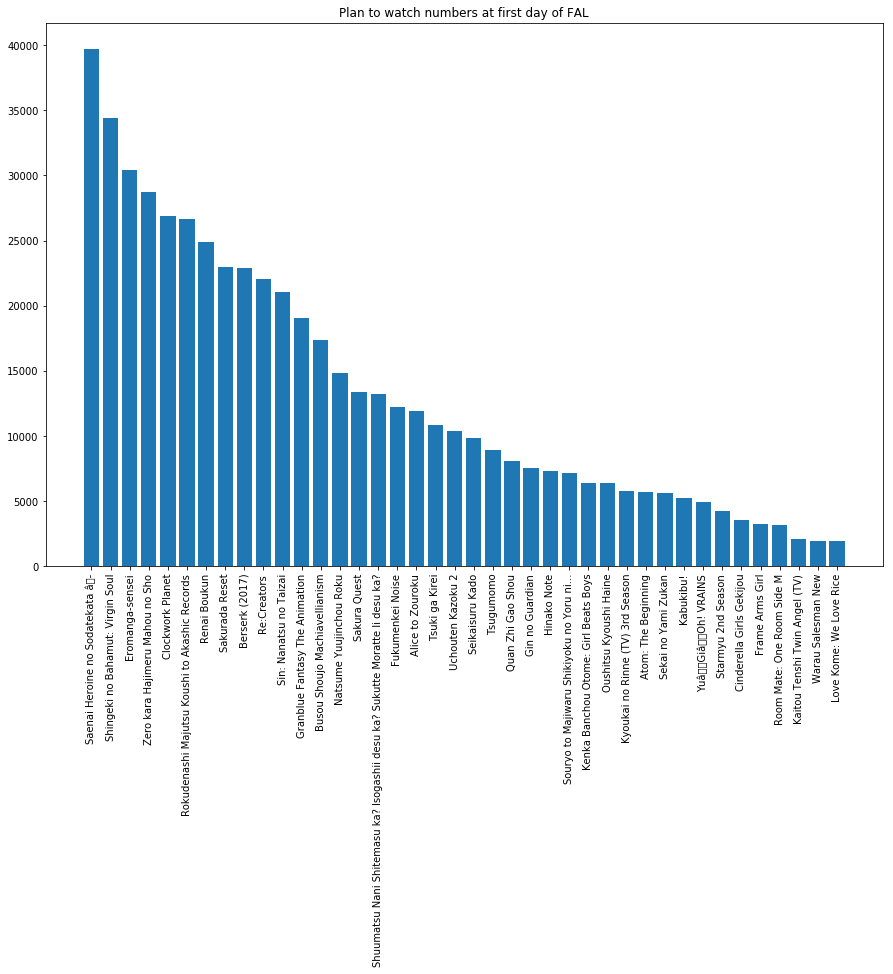

In [8]:
query = SESSION.query(Anime.title, Statistics.plantowatch).join(Statistics, Statistics.anime==Anime.id).filter(
    Statistics.day==0, ~Anime.title.in_(filtered_titles)).order_by(Statistics.plantowatch.desc()).all()
anime_titles, plantowatch_stats = zip(*query)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.bar(tuple(range(len(anime_titles))), plantowatch_stats)
ax.set_xticklabels(anime_titles)
plt.xticks(tuple(range(len(anime_titles))), rotation="vertical")
plt.title("Plan to watch numbers at first day of FAL")
plt.show()